In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as message
from biogeme import expressions as ex
import pandas as pd
import numpy as np
from scipy import stats
import xlsxwriter
from quetzal.io import excel

# Calibration
## Estimation of the model parameters
quetzal_germany is being estimated using [PandasBiogeme](https://biogeme.epfl.ch/). This notebook estimates calibration parameters for the model's utility functions.
- Documentation and reference: [Bierlaire, M. (2020). A short introduction to PandasBiogeme. Technical report TRANSP-OR 200605. Transport and Mobility Laboratory, ENAC, EPFL.](https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf)
- Tutorial: https://www.youtube.com/watch?v=OiM94B8WayA

### Model formulation
The model consists of systematic utility functions, one for each mode. They comprise an alternaive-specific constant (ASC), a distance-dependent part with travel time and cost, and a cost damping function F

$V_{im} = ASC_{im} + F(T_m, b_{c_i}) + C_{m_i} b_{c_i}$

Index i marks the demand group

In [3]:
input_path = '../input/'
model_path = '../model/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

### Prepare the database

In [5]:
df = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
df = df[['cost_rail_short', 'cost_rail_long', 'cost_car', 'cost_coach', 'cost_bus', 'cost_walk', 'cost_air',
         'time_rail_short', 'time_rail_long', 'time_car', 'time_coach', 'time_bus', 'time_walk', 'time_air',
         'cost_rail', 'cost_road', 'time_rail', 'time_road',
         'waiting_time_rail_short', 'waiting_time_rail_long', 'waiting_time_coach', 'waiting_time_bus', 'waiting_time_air',
         'mode_model', 'purpose_model', 'car_avail', 'length', 'W_GEW']]
df.columns = ['C_RAIL_Sc', 'C_RAIL_L', 'C_CAR', 'C_COACH', 'C_BUS', 'C_NON_MOTOR', 'C_AIR',
              'T_RAIL_Sc', 'T_RAIL_L', 'T_CAR', 'T_COACH', 'T_BUS', 'T_NON_MOTOR', 'T_AIR',
              'C_RAIL', 'C_ROAD', 'T_RAIL', 'T_ROAD',
              'WT_RAIL_Sc', 'WT_RAIL_L', 'WT_COACH', 'WT_BUS', 'WT_AIR',
              'MODE', 'PURPOSE', 'CAR_AV', 'DIST', 'W_GEW']

In [6]:
# The estimation requires numerical purpose values
p_dict = {'commuting':1, 'business':2, 'education':3, 'buy/execute':4, 'leisure':6, 'accompany':7}
df['PURPOSE'] = df['PURPOSE'].apply(lambda s: p_dict[s.split('_')[0]])

In [7]:
inf = 10000
df = df.replace({np.inf:inf})

In [8]:
# Scale time to hours
df['T_RAIL_S'] = df['T_RAIL'] / 60
df['T_RAIL_Sc_S'] = df['T_RAIL_Sc'] / 60
df['T_RAIL_L_S'] = df['T_RAIL_L'] / 60
df['T_CAR_S'] = df['T_CAR'] / 60
df['T_COACH_S'] = df['T_COACH'] / 60
df['T_BUS_S'] = df['T_BUS'] / 60
df['T_ROAD_S'] = df['T_ROAD'] / 60
df['T_AIR_S'] = df['T_AIR'] / 60
df['T_NON_MOTOR_S'] = df['T_NON_MOTOR'] / 60

In [9]:
# Scale waiting times from model seconds to minutes
# and generate aggregated values
df['WT_RAIL'] = (np.minimum(df['WT_RAIL_Sc'], df['WT_RAIL_L']) / 60).astype(int)
df['WT_ROAD'] = (np.minimum(df['WT_COACH'], df['WT_BUS']) / 60).astype(int)
df['WT_AIR'] = (df['WT_AIR'] / 60).astype(int)

In [10]:
# Make car availability binary
df['CAR_AV'] = df['CAR_AV'].replace({9:0})

In [11]:
# Add PT availabilities
df['RAIL_AV'] = (df['T_RAIL']!=inf).astype(int)
df['RAIL_Sc_AV'] = (df['T_RAIL_Sc']!=inf).astype(int)
df['RAIL_L_AV'] = (df['T_RAIL_L']!=inf).astype(int)
df['COACH_AV'] = (df['T_COACH']!=inf).astype(int)
df['BUS_AV'] = (df['T_BUS']!=inf).astype(int)
df['ROAD_AV'] = (df['T_ROAD']!=inf).astype(int)
df['AIR_AV'] = (df['T_AIR']!=inf).astype(int)
df['NON_MOTOR_AV'] = (df['T_NON_MOTOR']!=inf).astype(int)

In [12]:
# Merge rail and road PT
df['MODE'] = df['MODE'].replace({2:1, 3:4})

In [13]:
# Remove trips where mode is car but the car availability is zero
# because it irritates the MLE algorithm
mask = ((df['MODE']==6) & (df['CAR_AV']==0))
drop_ratio = len(df.loc[mask])/len(df.loc[df['MODE']==6])
lengths = list(df.loc[mask, 'DIST'])
print('Share of car trips dropped: {}'.format(drop_ratio))
df = df.loc[~mask]
# Drop other modes equally
#for m in [1,4]:
#    n_drops = int(np.round(drop_ratio * len(df.loc[df['MODE']==m])))
#    df = df.drop(df.loc[(df['MODE']==m) & (df['DIST']<max(lengths)) &
#                        (df['DIST']>min(lengths))].sample(n_drops).index)
#    print('Dropped ' + str(n_drops) + ' trips of mode ' + str(m))
print(len(df))

Share of car trips dropped: 0.011527377521613832
132004


In [14]:
# Check that PT trips have no infinity cost
for mode, col in zip([1, 4, 5], ['RAIL_AV', 'ROAD_AV', 'AIR_AV']):
    assert len(df.loc[((df['MODE']==mode) & (df[col]==inf))].index) == 0, str(mode)

### Model variables
All columns are variables. DefineVariable creates a new column in the database.

#### Generalised cost

Both, travel time and monetary cost should be affected by cost damping measures. It is logical to define a generalised cost term `GC` with dimension of time units. This requires definition or estimation of values of time, in order to rescale monetary units, for all segments. Usually, the value of time (VoT) is distance-dependent. In the case of Germany, VoT can be taken from research undertaken within the Federal Government's transport study "Bundesverkehrswegeplan 2030": Axhausen et al. 2015. Ermittlung von Bewertungsansätzen für Reisezeiten und Zuverlässigkeit auf der Basis eines Modells für modale Verlagerungen im nicht-gewerblichen und gewerblichen Personenverkehr für die Bundesverkehrswegeplanung

In [15]:
# VoT from literature, distance-dependent, see cal19
p_Fz_dict = {1:'Fz1', 3:'Fz2', 4:'Fz3', 2:'Fz4', 6:'Fz6', 7:'Fz6'}
VoT = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0)
VoT.sample(2)

,root,Fz1,Fz2,Fz3,Fz4,Fz6,root,Fz1,Fz2,Fz3,...,Fz2,Fz3,Fz4,Fz6,root,Fz1,Fz2,Fz3,Fz4,Fz6
,all,all,all,all,all,all,PT,PT,PT,PT,...,air,air,air,air,car,car,car,car,car,car
961,24.2357,23.1269,9.18,11.9,34.3292,17.9251,18.1339,13.6126,13.48,18.0426,...,102.6945,102.6945,292.0983,56.4434,23.9013,22.5903,13.9709,29.9799,26.9265,17.9251
249,15.0012,14.4420,9.18,11.9,16.6944,11.7976,11.4664,9.1608,13.48,13.6008,...,25.5916,25.5916,27.1944,18.0052,14.9516,14.3032,9.3104,19.2680,16.0104,11.7976


In [16]:
# Make distance integer
df['DIST'] = df['DIST'].apply(int)

In [17]:
df = df.loc[df['DIST']<=1000]
len(df)

132004

In [18]:
# Generate generalised cost
VoT = VoT.to_dict()
df['GC_RAIL'] = df['T_RAIL_S'] + [c / VoT[(p_Fz_dict[p], 'PT')][d]
                                  for c,d,p in zip(df['C_RAIL'], df['DIST'], df['PURPOSE'])]
df['GC_RAIL_Sc'] = df['T_RAIL_Sc_S'] + [c / VoT[(p_Fz_dict[p], 'PT')][d]
                                        for c,d,p in zip(df['C_RAIL_Sc'], df['DIST'], df['PURPOSE'])]
df['GC_RAIL_L'] = df['T_RAIL_L_S'] + [c / VoT[(p_Fz_dict[p], 'PT')][d]
                                      for c,d,p in zip(df['C_RAIL_L'], df['DIST'], df['PURPOSE'])]
df['GC_COACH'] = df['T_COACH_S'] + [c / VoT[(p_Fz_dict[p], 'PT')][d]
                                    for c,d,p in zip(df['C_COACH'], df['DIST'], df['PURPOSE'])]
df['GC_BUS'] = df['T_BUS_S'] + [c / VoT[(p_Fz_dict[p], 'PT')][d]
                                for c,d,p in zip(df['C_BUS'], df['DIST'], df['PURPOSE'])]
df['GC_ROAD'] = df['T_ROAD_S'] + [c / VoT[(p_Fz_dict[p], 'PT')][d]
                                  for c,d,p in zip(df['C_ROAD'], df['DIST'], df['PURPOSE'])]
df['GC_AIR'] = df['T_AIR_S'] + [c / VoT[(p_Fz_dict[p], 'air')][d]
                                for c,d,p in zip(df['C_AIR'], df['DIST'], df['PURPOSE'])]
df['GC_CAR'] = df['T_CAR_S'] + [c / VoT[(p_Fz_dict[p], 'car')][d]
                                for c,d,p in zip(df['C_CAR'], df['DIST'], df['PURPOSE'])]
df['GC_NON_MOTOR'] = df['T_NON_MOTOR_S']

<AxesSubplot:>

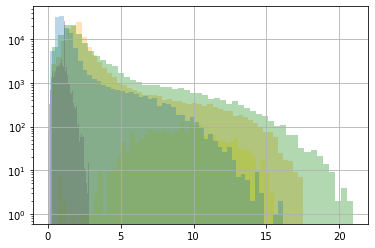

In [19]:
# Distribution of generalised cost by mode
df.loc[df['CAR_AV']==1, 'GC_CAR'].hist(log=True,
    bins=50, alpha=.3, ax=df.loc[df['RAIL_AV']==1, 'GC_RAIL'].hist(log=True,
        bins=50, color='green', alpha=.3, ax=df.loc[df['ROAD_AV']==1, 'GC_ROAD'].hist(log=True,
            bins=50, color='orange', alpha=.3, ax=df.loc[df['NON_MOTOR_AV']==1, 'GC_NON_MOTOR'].hist(log=True,
                bins=50, color='purple', alpha=.3, ax=df.loc[df['AIR_AV']==1, 'GC_AIR'].hist(log=True,
                    bins=50, color='yellow', alpha=.3)))))

<AxesSubplot:>

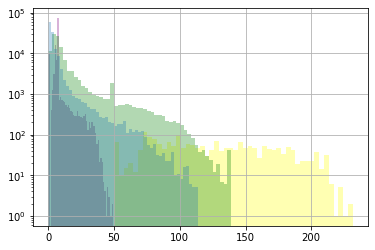

In [20]:
# Distribution of prices by mode
df.loc[df['CAR_AV']==1, 'C_CAR'].hist(log=True,
    bins=50, alpha=.3, ax=df.loc[df['RAIL_AV']==1, 'C_RAIL'].hist(log=True,
        bins=50, color='green', alpha=.3, ax=df.loc[df['ROAD_AV']==1, 'C_ROAD'].hist(log=True,
#            bins=50, color='orange', alpha=.3, ax=df.loc[df['NON_MOTOR_AV']==1, 'C_NON_MOTOR'].hist(log=True,
                bins=50, color='purple', alpha=.3, ax=df.loc[df['AIR_AV']==1, 'C_AIR'].hist(log=True,
                    bins=50, color='yellow', alpha=.3))))#)

<AxesSubplot:>

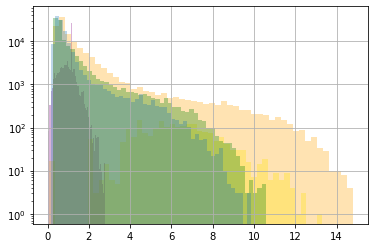

In [21]:
# Distribution of travel times by mode
df.loc[df['CAR_AV']==1, 'T_CAR_S'].hist(log=True,
    bins=50, alpha=.3, ax=df.loc[df['RAIL_AV']==1, 'T_RAIL_S'].hist(log=True,
        bins=50, color='green', alpha=.3, ax=df.loc[df['ROAD_AV']==1, 'T_ROAD_S'].hist(log=True,
            bins=50, color='orange', alpha=.3, ax=df.loc[df['NON_MOTOR_AV']==1, 'T_NON_MOTOR_S'].hist(log=True,
                bins=50, color='purple', alpha=.3, ax=df.loc[df['AIR_AV']==1, 'T_AIR_S'].hist(log=True,
                    bins=50, color='yellow', alpha=.3)))))

#### Cost damping

Many modelling studies have shown that cost damping is required in order to flatten the tail of time/cost elasticities, i.e. decrease the impact of long distances on choice results to prevent from overestimation of time/cost parameters. Cost damping represents the property of decreasing marginal utility. It is commonly approached with Box-Cox transformations of generalised cost (usually defined as the sum of travel time and travel expenditures divided by the value of time). Daly (2010) proposes a hybrid function as a sum of the linear term and the narural logarithm of the same. However, the linear term still dominates cost on long distances. Rich (2020), main developer of the Danish National Transport Model, proposes a more complex spline function which successfully manages cost damping and even outperforms the Box-Cox transformation in terms of stability of elasticities.

In [22]:
# The cost damping function from Rich (2020)
c = params['estimation']
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*ex.Power(ex.log(c1),3),
             -beta/2*ex.log(c1)*(3*ex.Power(ex.log(c2),2)+ex.Power(ex.log(c1),2))] # for Q=3
    theta = [1, 3/2*ex.log(c1), 3*ex.log(c1)*ex.log(c2)] # for Q=3
    return (beta*theta[0]*ex.Power(ex.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*ex.Power(ex.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*ex.Power(ex.log(x),Q-3+1) + alpha[2]) * (x>=c2)

In [23]:
# A Box-Cox transformation can be applied with the following code.
# However, it performs worse than other estimations
#tao_t = {}
#for m in ['CAR', 'RAIL', 'ROAD', 'AIR', 'NON_MOTOR']:
#    assert len(df.loc[df['T_'+m+'_S']<=0]) == 0
#    transformed_data, best_tao = stats.boxcox(df.loc[df[m+'_AV']==1, 'T_'+m+'_S'])
#    tao_t[m] = best_tao
#    df.loc[df[m+'_AV']==1, 'T_'+m+'_D'] = transformed_data
#    df.loc[df[m+'_AV']==0, 'T_'+m+'_D'] = inf

### Database creation

In [24]:
# Create the initial database and make columns global variables
database = db.Database('MiD2017', df.copy())
globals().update(database.variables)
database.getSampleSize()

132004

### Estimation parameters

In [25]:
asc_rail = ex.Beta('asc_rail', 0, None, None, 0)
asc_rail_s = ex.Beta('asc_rail_s', 0, None, None, 0)
asc_rail_l = ex.Beta('asc_rail_l', 0, None, None, 0)
asc_coach = ex.Beta('asc_coach', 0, None, None, 0)
asc_bus = ex.Beta('asc_bus', 0, None, None, 0)
asc_road = ex.Beta('asc_road', 0, None, None, 0)
asc_air = ex.Beta('asc_air', 0, None, None, 0)
asc_car = ex.Beta('asc_car', 0, None, None, 1)
asc_non_motor = ex.Beta('asc_non_motor', 0, None, None, 0)

In [26]:
b_t = ex.Beta('b_t', 0, None, None, 0)
b_c = ex.Beta('b_c', 0, None, None, 0)
b_wt = ex.Beta('b_wt', 0, None, None, 0)

In [27]:
# generalised cost function parameter
b_gc = ex.Beta('b_gc', 0, None, None, 0)

In [28]:
# Parameters for the nested logit structure
mu_pt = ex.Beta('mu_pt', 1, 1, 10, 0)

### Utility functions

In [29]:
# Model specification with spline function transformation - disaggregated
p_dict_rev = dict(zip(p_dict.values(), p_dict.keys()))
car = '_car' # take the knot points for car available
V_RAIL = {p: asc_rail
              + C_RAIL * b_c
              + spline(T_RAIL, b_t, c['c1_time_'+p_dict_rev[p]+car]*60, c['c2_time_'+p_dict_rev[p]+car]*60)
          for p in df['PURPOSE'].unique()}
V_ROAD = {p: asc_road
              + C_ROAD * b_c
              + spline(T_ROAD, b_t, c['c1_time_'+p_dict_rev[p]+car]*60, c['c2_time_'+p_dict_rev[p]+car]*60)
          for p in df['PURPOSE'].unique()}
V_AIR = {p: asc_air
             + C_AIR * b_c
             + spline(T_AIR, b_t, c['c1_time_'+p_dict_rev[p]+car]*60, c['c2_time_'+p_dict_rev[p]+car]*60)
         for p in df['PURPOSE'].unique()}
V_CAR = {p: asc_car
             + C_CAR * b_c
             + spline(T_CAR, b_t, c['c1_time_'+p_dict_rev[p]+car]*60, c['c2_time_'+p_dict_rev[p]+car]*60)
         for p in df['PURPOSE'].unique()}
V_NON_MOTOR = {p: asc_non_motor 
                   + spline(T_NON_MOTOR, b_t, c['c1_time_'+p_dict_rev[p]+car]*60, c['c2_time_'+p_dict_rev[p]+car]*60)
               for p in df['PURPOSE'].unique()}

# Model specification for business trips
V_RAIL[2] = asc_rail + spline(T_RAIL, b_t, c['c1_time_business'+car]*60, c['c2_time_business'+car]*60)
V_ROAD[2] = asc_road + spline(T_ROAD, b_t, c['c1_time_business'+car]*60, c['c2_time_business'+car]*60)
V_AIR[2] = asc_air + spline(T_AIR, b_t, c['c1_time_business'+car]*60, c['c2_time_business'+car]*60)
V_CAR[2] = asc_car + spline(T_CAR, b_t, c['c1_time_business'+car]*60, c['c2_time_business'+car]*60)
V_NON_MOTOR[2] = asc_non_motor + spline(T_NON_MOTOR, b_t, c['c1_time_business'+car]*60, c['c2_time_business'+car]*60)

### Run the estimation

In [30]:
# Define level of verbosity
logger = message.bioMessage()
#logger.setSilent()
logger.setWarning()
#logger.setGeneral()
#logger.setDetailed()

In [31]:
# Map modes to utility functions
V = {p: {1:V_RAIL[p],
         4:V_ROAD[p],
         5:V_AIR[p],
         6:V_CAR[p],
         7:V_NON_MOTOR[p]}
     for p in df['PURPOSE'].unique()}

In [32]:
# Map the availability of alternatives with MODE as key
# PT is always available
av = {p: {1:RAIL_AV,
          4:ROAD_AV,
          5:AIR_AV,
          6:CAR_AV,
          7:NON_MOTOR_AV}
      for p in df['PURPOSE'].unique()}

In [33]:
# Mode nests as tuples with nest name and dictionary where
# alternative IDs are mapped to alpha values. Missing ID's alpha is zero
# Alternatively use lists with mode ID without alpha
pt = mu_pt, [1, 4]#[1, 2, 3, 4]
air = 1, [5]
car = 1, [6]
walk = 1, [7]
nests = pt, air, car, walk

In [34]:
# Write results to an Excel file
writer = pd.ExcelWriter(input_path + 'estimation_results.xls', engine='xlsxwriter')

In [35]:
# Choose the multinomial logit model
mnl = models.loglogit(V[6], av[6], MODE)

In [36]:
database = db.Database('MiD2017', df.sample(3000))
#database.remove(PURPOSE!=4)
model_mnl = bio.BIOGEME(database, mnl, numberOfThreads=10)
model_mnl.modelName = 'MNL'
model_mnl.generateHtml = False
model_mnl.generatePickle = False

In [37]:
results_mnl = model_mnl.estimate()

[22:14:36] < Warning >   Cannot read file __MNL.iter. Statement is ignored.


In [38]:
results = results_mnl.getEstimatedParameters()
for key, val in results_mnl.getGeneralStatistics().items():
    results.loc[key] = [val[0], val[1]] + ['' for i in range(len(results.columns)-2)]
results

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
asc_air,-1.315265,1.075315,-1.223144,0.221275,1.030782,-1.275988,0.20196
asc_non_motor,-4.386997,0.243736,-17.998963,0.0,0.238805,-18.370608,0.0
asc_rail,-2.601624,0.091851,-28.324248,0.0,0.093502,-27.824223,0.0
asc_road,-2.814482,0.102432,-27.476583,0.0,0.104434,-26.949938,0.0
b_c,-0.043452,0.007177,-6.054309,0.0,0.009035,-4.809506,0.000002
b_t,-0.018527,0.004264,-4.344806,0.000014,0.00402,-4.608347,0.000004
Number of estimated parameters,6.000000,,,,,,
Sample size,3000.000000,,,,,,
Excluded observations,0.000000,,,,,,
Init log likelihood,-3616.747218,.7g,,,,,


In [39]:
results.to_excel(writer, sheet_name=model_mnl.modelName)

In [40]:
# Choose the logarithmic nested logit model
nl = models.lognested(V[6], av[6], nests, MODE)

In [41]:
# Nested Logit
model_nl = bio.BIOGEME(database, nl, numberOfThreads=10)
model_nl.modelName = 'NL'
model_nl.generateHtml = False
model_nl.generatePickle = False

In [42]:
results_nl = model_nl.estimate()

[22:15:29] < Warning >   Cannot read file __NL.iter. Statement is ignored.


In [43]:
results = results_nl.getEstimatedParameters()
for key, val in results_nl.getGeneralStatistics().items():
    results.loc[key] = [val[0], val[1]] + ['' for i in range(len(results.columns)-2)]
results

,Value,Active bound,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
asc_air,-1.315832,0.0,1.202303,-1.094427,0.273768,1.610946,-0.816807,0.414039
asc_non_motor,-4.386922,0.0,0.246369,-17.806321,0.0,0.259354,-16.914793,0.0
asc_rail,-2.601642,0.0,0.158083,-16.4574,0.0,0.297775,-8.736949,0.0
asc_road,-2.814486,0.0,0.265875,-10.585766,0.0,0.605492,-4.648263,0.000003
b_c,-0.043450,0.0,0.014782,-2.9393,0.00329,0.037276,-1.165631,0.243764
b_t,-0.018527,0.0,0.004327,-4.28157,0.000019,0.004537,-4.083546,0.000044
mu_pt,1.000000,1.0,0.354455,2.821231,0.004784,0.859145,1.163947,0.244445
Number of estimated parameters,7.000000,,,,,,,
Number of free parameters,6.000000,,,,,,,
Sample size,3000.000000,,,,,,,


In [44]:
results.to_excel(writer, sheet_name=model_nl.modelName)

In [45]:
# Run the estimation by purpose
# These purposes are differentiated by car availability
car_str = ['_no_car', '_car']
results = []
for p in df['PURPOSE'].unique():
    for car in [0,1]:
        mask = (df['PURPOSE']==p) & (df['CAR_AV']==car)
        database = db.Database('MiD2017', df.loc[mask].copy())
        print('Sample size for purpose {}, car {}: {}'.format(p, car, database.getSampleSize()))
        mnl = models.loglogit(V[p], av[p], MODE) # Choose utility functions and availabilities
        formulas = {'loglike': mnl, 'weight': W_GEW} # give weights to the estimator
        model = bio.BIOGEME(database, formulas, numberOfThreads=10)
        model.generateHtml = False
        model.generatePickle = False
        model.modelName = p_dict_rev[p].replace('/', '-') + car_str[car] # Name it
        results.append(model.estimate()) # Estimation
        output = results[-1].getEstimatedParameters()
        # Add results to the Excel file
        for key, val in results[-1].getGeneralStatistics().items():
            output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
        output.to_excel(writer, sheet_name=model.modelName)

Sample size for purpose 6, car 0: 906
[22:15:56] < Warning >   Cannot read file __leisure_no_car.iter. Statement is ignored.
Sample size for purpose 6, car 1: 39466
[22:15:58] < Warning >   Cannot read file __leisure_car.iter. Statement is ignored.
Sample size for purpose 7, car 0: 41
[22:16:05] < Warning >   Cannot read file __accompany_no_car.iter. Statement is ignored.
Sample size for purpose 7, car 1: 8959
[22:16:06] < Warning >   Cannot read file __accompany_car.iter. Statement is ignored.
Sample size for purpose 1, car 0: 735
[22:16:09] < Warning >   Cannot read file __commuting_no_car.iter. Statement is ignored.
Sample size for purpose 1, car 1: 32822
[22:16:11] < Warning >   Cannot read file __commuting_car.iter. Statement is ignored.
Sample size for purpose 4, car 0: 537
[22:16:21] < Warning >   Cannot read file __buy-execute_no_car.iter. Statement is ignored.
Sample size for purpose 4, car 1: 35991
[22:16:23] < Warning >   Cannot read file __buy-execute_car.iter. Statement is

In [46]:
writer.save()